In [2]:
import tensorflow as tf
import os
import random

In [3]:
tf.__version__

'2.14.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()

target_dataset = "food101"

print(f"'{target_dataset}'in tensorflow datasets: {target_dataset in datasets_list}")

'food101'in tensorflow datasets: True


In [6]:
(train_data, test_data), ds_info = tfds.load(name = "food101",  #Target ddataset name
                                             split = ["train", "validation"], # after splitting data what should we get? ex. here train and validation folder
                                             shuffle_files = True, #To shuffle files on download
                                             as_supervised = True,  # Download data in tuple format
                                             with_info = True)  #include datasets Metadeta

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
#Get class names
class_names = ds_info.features['label'].names

class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
train_sample = train_data.take(1)

In [10]:
train_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
#Output info about training example
for image, label in train_sample:
  print(f"""  Image shape :    {image.shape}
  Image dtype:     {image.dtype}
  target class id: {label}
  Class name:      {class_names[label.numpy()]} """)

  Image shape :    (512, 512, 3)
  Image dtype:     <dtype: 'uint8'>
  target class id: 8
  Class name:      bread_pudding 


(-0.5, 511.5, 511.5, -0.5)

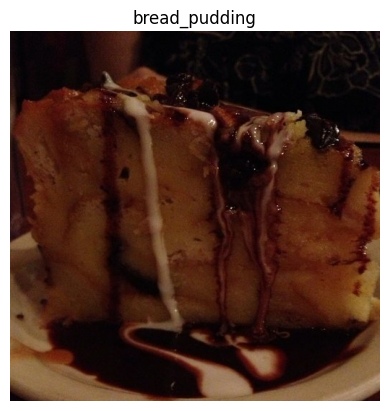

In [12]:
#plottimg an image

import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [13]:
def preprocess_img(image, label, img_shape = 224):
  '''
  Converts image datatype from 'uint8' to 'float32'
  and reshapes image to [ img_shape, img_shape, color_channel]
  '''

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32) , label

In [14]:
preprocessed_img = preprocess_img(image, label)[0]

preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[20.158163 ,  8.158163 , 10.158163 ],
        [18.42347  ,  7.6173472,  9.020408 ],
        [15.010203 ,  6.423469 ,  9.285714 ],
        ...,
        [26.285824 , 15.714351 , 23.07156  ],
        [31.091867 , 17.285728 , 24.285728 ],
        [28.754953 , 13.754952 , 20.754953 ]],

       [[18.92857  ,  8.928571 ,  9.928571 ],
        [16.214285 ,  7.0765305,  8.07653  ],
        [14.739796 ,  8.571429 , 10.627552 ],
        ...,
        [26.444029 , 15.872557 , 21.658293 ],
        [39.86226  , 26.862259 , 33.86226  ],
        [39.49479  , 24.494787 , 31.494787 ]],

       [[17.066326 ,  8.709184 ,  9.494898 ],
        [16.255102 , 10.086736 , 10.142858 ],
        [15.142857 ,  9.908163 , 11.52551  ],
        ...,
        [26.688967 , 16.117495 , 21.474659 ],
        [34.18364  , 22.183641 , 26.183641 ],
        [39.199165 , 24.199165 , 28.770594 ]],

       ...,

       [[13.862259 ,  4.862259 ,  7.862259 ],
        [11.2

(-0.5, 223.5, 223.5, -0.5)

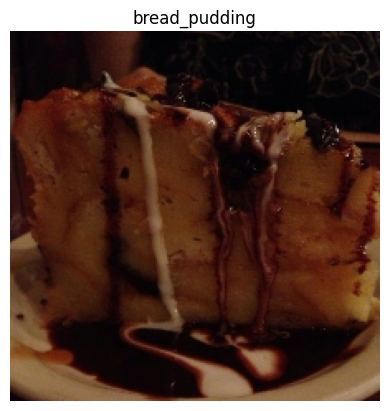

In [15]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

In [16]:
#Map preprcessing function on train data
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

#Map preprcessing function on test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [18]:
checkpoint_path = "model_checkpoint/ck.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [19]:
#setting up mixed precision

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = "mixed_float16")

In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [21]:
from tensorflow.keras import layers

#create base model

input_shape = (224, 224, 3)
base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top = False)
base_model.trainable = False

#Create model with keras Functional api

inputs = layers.Input(shape = input_shape, name = "input_layer")
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

In [23]:
#checking dtypes attributes of layers in out=r model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
resnet50v2 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [24]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pre

In [25]:
tf.get_logger().setLevel("ERROR")

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks = [model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 193s 75ms/step - loss: 2.3088 - accuracy: 0.4464 - val_loss: 1.7867 - val_accuracy: 0.5371
Epoch 2/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.7499 - accuracy: 0.5600 - val_loss: 1.7347 - val_accuracy: 0.5508
Epoch 3/3
2368/2368 [==============================] - 176s 73ms/step - loss: 1.5438 - accuracy: 0.6027 - val_loss: 1.7424 - val_accuracy: 0.5678


In [26]:
result = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.7593 - accuracy: 0.5609


In [27]:
#  Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

## Preparing model for fine tunning

In [29]:
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.dtype, layer.trainable)

input_layer float32 True
rescaling float32 True
resnet50v2 float32 True
pooling_layer float32 True
dense float32 True
softmax_float32 float32 True


In [ ]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

In [33]:
#using early stopping callback when 'val_loss' stops to improving further more.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3)

#Create Modelcheckpoint callback to save best model during fione tunning

checkpoint_path = "fine_tune_checkpoint/"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = "val_loss")

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_lr = 1e-7)

In [36]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(0.0001),
              metrics = ["accuracy"])

In [37]:
history_101_food_classes_all_data_fine = model.fit(train_data,
                                                   epochs = 100,
                                                   steps_per_epoch = len(train_data),
                                                   validation_data = test_data,
                                                   validation_steps = int(0.15 * len(test_data)),
                                                   callbacks  = [model_checkpoint,
                                                                 early_stopping, reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 388s 148ms/step - loss: 1.8074 - accuracy: 0.5383 - val_loss: 1.3620 - val_accuracy: 0.6390 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 359s 150ms/step - loss: 1.2394 - accuracy: 0.6696 - val_loss: 1.2640 - val_accuracy: 0.6647 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 352s 147ms/step - loss: 0.8923 - accuracy: 0.7517 - val_loss: 1.2361 - val_accuracy: 0.6835 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 322s 135ms/step - loss: 0.6332 - accuracy: 0.8171 - val_loss: 1.3865 - val_accuracy: 0.6541 - lr: 1.0000e-04
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4596 - accuracy: 0.8630
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 319s 134ms/step - loss: 0.4598 - accuracy: 0.8629 - val_loss: 1.3735 - val_accuracy: 0.6737 - lr: 1.0000e-04
Epoch 

In [39]:
model.save("resnet50_fine_tune_food_101.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
result_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.3519 - accuracy: 0.7340


In [97]:
def plot_loss_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history["val_accuracy"]

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))



  plt.figure()
  plt.plot( epochs,loss, label = 'training_loss')
  plt.plot( epochs,val_loss, label = 'validation_loss')
  plt.title("Loss")
  plt.xlabel('epochs')
  plt.legend();

  plt.figure()
  plt.plot(epochs,acc ,label = 'training_accuracy')
  plt.plot( epochs,val_acc, label = 'validation_accuracy')
  plt.title("Accuracy")
  plt.xlabel('epochs')
  plt.legend();


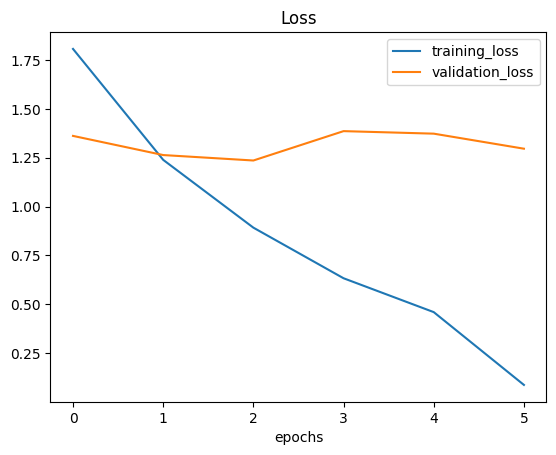

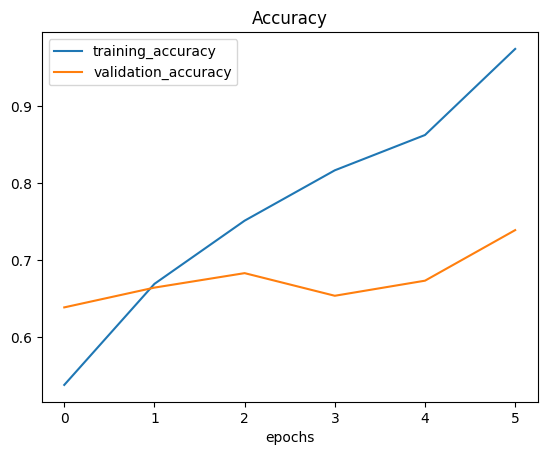

In [98]:
plot_loss_curves(history_101_food_classes_all_data_fine)

It seems like overfitting

In [105]:
#Make prediction with the model we have trained
pred_prob = model.predict(test_data, verbose = 1)

790/790 [==============================] - 57s 72ms/step


In [106]:
len(pred_prob)

25250

In [100]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [101]:
len(y_labels)

25250

In [86]:
image_path = "/content/61b31c9d289e22335b6753b2_Ice Cream 2.jpg"

img = plt.imread(image_path)


Text(0.5, 1.0, 'miso_soup')

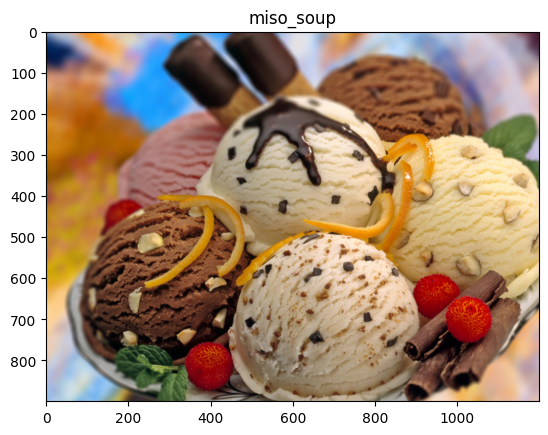

In [87]:
plt.imshow(img)
plt.title(class_names[label.numpy()])

In [71]:
img_size = 224


import cv2
image = tf.image.resize(img, [img_size, img_size])


In [72]:
prediction = model.predict(tf.expand_dims(image, axis = 0))

1/1 [==============================] - 0s 27ms/step


In [73]:
import numpy as np
class_id = np.argmax(prediction)

In [74]:
class_id

58

In [76]:
class_names[class_id]

'ice_cream'